<a href="http://landlab.github.io"><img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"></a> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# Getting to know the Landlab component library

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/component_tutorial/component_tutorial_unexpanded.ipynb">http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/component_tutorial/component_tutorial_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This ipython notebook walks you through the stages of creating and running a Landlab model using the Landlab component library.

We are going to create three models—firstly a single component driver implementing just linear diffusion; then a three-component driver implementing linear diffusion, flow routing, and stream power incision; and finally a similar model, but implementing a storm-interstorm sequence.

# The basics: one component

Let's begin with the one-component diffusion model.

Firstly, import the library elements we'll need. The component classes can all be imported from the `landlab.components` library. They're all formatted in CamelCaseLikeThis. Anything you see in that folder that isn't formatted like this isn't a component!

In [1]:
from landlab.components import LinearDiffuser
from landlab.plot import imshow_grid
from landlab import RasterModelGrid, CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
import numpy as np

Let's start by creating the grid that we'll do the first part of this exercise with, and putting some data into its fields. Note that you need to create the fields that a component takes as inputs *before* instantiating a component - though you can put values into the arrays later if you need to (as illustrated below). For more info on working with fields, see the *fields* tutorial.

In [2]:
mg = RasterModelGrid((80, 80), 5.)
z = mg.add_zeros('node', 'topographic__elevation')

How did we know this was a field we needed as an input? Well, firstly because we read the component documentation (**always do this!**), but secondly we can get a reminder using the Landlab Component Standard Interface:

In [3]:
LinearDiffuser.input_var_names

('topographic__elevation',)

Note we didn't have to instantiate the component to be able to do this! Other standard properties are `output_var_names` and `optional_var_names`; pass an input or output name to `var_loc`, `var_type`, `var_units`, and `var_definition` to get the centering ('node', 'link', etc), array dtype (float, int), units (meters, etc) and a descriptive string, respectively. `var_help` will dive you a lot of this information at once:

In [4]:
LinearDiffuser.var_help('topographic__elevation')

name: topographic__elevation
description:
  Land surface topographic elevation; can be overwritten in
  initialization
units: m
at: node
intent: inout


It's also a good idea to set the grid boundary conditions before component instantiation. Let's have fixed value top and bottom and closed left and right:

In [5]:
for edge in (mg.nodes_at_left_edge, mg.nodes_at_right_edge):
    mg.status_at_node[edge] = CLOSED_BOUNDARY
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge):
    mg.status_at_node[edge] = FIXED_VALUE_BOUNDARY

Landlab components have undergone something of a stylistic overhaul in Landlab version 1. You should now find that all components within landlab share a similar interface. We'll examine how it looks first on the diffusion component.

Landlab components now have a standardised instantiation signature. A key difference to what you may have seen before is that the inputs to the component are now fed in as *dynamic Python objects*, i.e., floats, strings, arrays, rather than being fed in as strings from a text input file (though note, you an still do this, see below). This has two major advantages: firstly, components now have plainly declared default values, that are visible just like they would be in, say, a numpy function; secondly, because the inputs are now Python objects, it's a lot easier to work with spatially variable inputs that need to be passed in as arrays, and also to feed dynamically changing inputs into a component.

The standard signature to instantiate a component looks like this:

    MyComponent(grid, input1=default1, input2=default2, input3=default3, ..., **kwds)

Because defaults are provided, you can instantiate a component with default values very simply; the diffuser requires only that a `linear_diffusity` be supplied:

In [6]:
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=0.2)

We'll see some other ways of initializing (e.g., from an input file) below.

Now we're ready to run the component! Run methods are also standardized. Almost all Landlab components have a standard run method named `run_one_step`, and it looks like this:

    my_comp.run_one_step([dt], other_inputA=defaultA, ...)

If the component is time-dependent, `dt`, the timestep, will be the first argument. Subsequent keywords will typically be flags that control the way the component runs, and typically can be left as their default values. Note that nothing is returned from a run method like this, but that nonetheless *the grid fields are updated*.

This `dt` is properly thought of as the *external model timestep*; it controls essentially the frequency at which the various Landlab components you're implementing can exchange information with each other and with the driver (e.g., frequency at which uplift steps are added to the grid). If your model has a stability condition which demands a shorter timestep, the external timestep will be subdivided internally down to this shorter timescale.

So let's do it. It's up to you as the component designer to make sure your driver script accounts properly for the total time the model runs. Here, we want to run for 200000 years with a timestep of 1000 years, with an uplift rate of 0.001 m/y. So:

In [7]:
total_t = 200000.
dt = 1000.
uplift_rate = 0.001
nt = int(total_t // dt)
# ^note if we didn't know a priori that there are a round number of steps dt in the
# total time, we'd have to take care to account for the "extra" time (see example below)
for i in range(nt):
    lin_diffuse.run_one_step(dt)
    z[mg.core_nodes] += uplift_rate * dt  # add the uplift
    # add some output to let us see we aren't hanging:
    if i % 50 == 0:
        print(i*dt)

0.0
50000.0
100000.0
150000.0


Note that we're using `z` to input the uplift here, which we already bound to the Landlab field `mg.at_node['topographic__elevation]` when we instantiated that field. This works great, but always be careful to update the values *inside* the array, not to reset the variable as equal to something else, i.e., to put new values in the field do::

    z[:] = new_values  # values copied into the existing field

not

    z = new_values  # z is now "new_values", not the field!

Now plot the output!

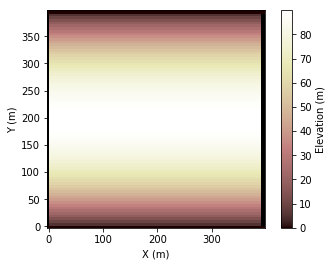

In [8]:
# the following line makes figures show up correctly in this document (only needed for iPython notebook)
%matplotlib inline

# Create a figure and plot the elevations
figure(1)
im = imshow_grid(mg, 'topographic__elevation', grid_units = ['m','m'],
                 var_name='Elevation (m)')

Text(0.5,1,'topographic__elevation cross section')

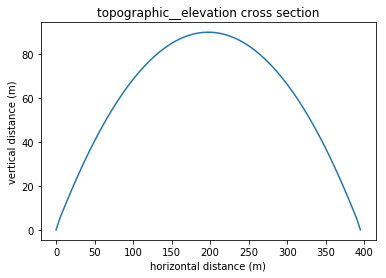

In [9]:
figure(2)
elev_rast = mg.node_vector_to_raster(z)
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ncols = mg.number_of_node_columns
im = plot(ycoord_rast[:, int(ncols // 2)], elev_rast[:, int(ncols // 2)])
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
title('topographic__elevation cross section')

Now, let's repeat this exercise, but illustrating the way we can input fields as some parameters for components. We're going to make the diffusivity spatially variable., falling by a factor of ten as we move across the grid.

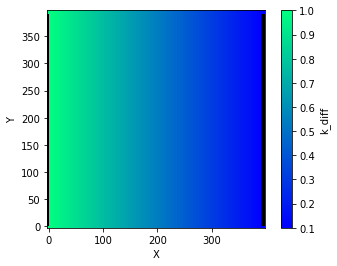

In [10]:
z[:] = 0.  # reset the elevations to zero
k_diff = mg.zeros('node', dtype=float)
k_diff.fill(1.)
k_diff *= (mg.node_x.max() - 0.9*mg.node_x)/mg.node_x.max()
k_field = mg.add_field('node', 'linear_diffusivity', k_diff, noclobber=False)
imshow_grid(mg, k_diff, var_name='k_diff', cmap='winter')  # check it looks good

Now we re-initialize the component instance to bind the k_diff field to the component:

In [11]:
lin_diffuse = LinearDiffuser(mg, linear_diffusivity='linear_diffusivity')
# we could also have passed in `k_diff` in place of the string

...and run just as before. Note this will be slower than before; the internal timestep is shorter because we've modified the diffusivities.

0.0
50000.0
100000.0
150000.0


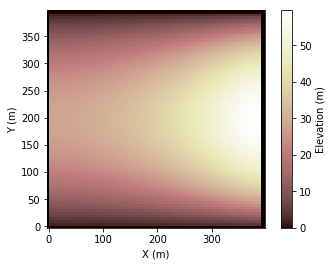

In [12]:
for i in range(nt):
    lin_diffuse.run_one_step(dt)
    z[mg.core_nodes] += uplift_rate * dt  # add the uplift
    # add some output to let us see we aren't hanging:
    if i % 50 == 0:
        print(i*dt)
figure(3)
im = imshow_grid(mg, 'topographic__elevation', grid_units = ['m','m'],
                 var_name='Elevation (m)')

# Running two or more components

Now we're going to take a similar approach but this time combine the outputs of three distinct Landlab components: the diffuser, the monodirectional flow router, and the stream power incisor. For clarity, we're going to repeat the whole process from the start.

So first, let's import everything we don't already have:

In [13]:
from landlab.components import FlowAccumulator, FastscapeEroder
from landlab import load_params

More components means more input parameters. So this time, we're going to make our lives easier by instantiating our components from an [input file](./coupled_params.txt). Note also that we've now switched length units to km from m.

We're going to handle our input file using the very powerful `load_params` Landlab function. This function can read input text files formatted in a variety of different ways, including both the Landlab-native style and also the yaml standard. It automatically types the values it finds in the input file (i.e., makes them int, float, string, etc.), and returns them as a Python dictionary. This dictionary is the model parameter dictionary (MPD). However, feel free to use your own way of reading in a text file. The important thing is that you end up with a **dictionary** that you can pass into the components that contains `'input_parameter_name': parameter_value` pairs.

Once we have the MPD, we're going to pull the parameters we need to make the grid and drive the components out of it (in part, to show that the MPD is a Python dictionary).

In [14]:
input_file = './coupled_params.txt'
inputs = load_params(input_file) # load the data into a dictionary

nrows = inputs['nrows']
ncols = inputs['ncols']
dx = inputs['dx']
uplift_rate = inputs['uplift_rate']
total_t = inputs['total_time']
dt = inputs['dt']

nt = int(total_t // dt) #this is how many loops we'll need
uplift_per_step = uplift_rate * dt

# illustrate what the MPD looks like:
print(inputs)

{'nrows': 100, 'ncols': 100, 'dx': 0.02, 'dt': 0.5, 'total_time': 100.0, 'uplift_rate': 0.001, 'K_sp': 0.3, 'm_sp': 0.5, 'n_sp': 1.0, 'rock_density': 2.7, 'sed_density': 2.7, 'linear_diffusivity': 0.0001}


Now instantiate the grid, set the initial conditions, and set the boundary conditions:

In [15]:
mg = RasterModelGrid((nrows, ncols), dx)
z = mg.add_zeros('node', 'topographic__elevation')
# add some roughness, as this lets "natural" channel planforms arise
initial_roughness = np.random.rand(z.size)/100000.
z += initial_roughness
for edge in (mg.nodes_at_left_edge, mg.nodes_at_right_edge):
    mg.status_at_node[edge] = CLOSED_BOUNDARY
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge):
    mg.status_at_node[edge] = FIXED_VALUE_BOUNDARY

So far, so familiar.

Now we're going to instantiate all our components, using the MPD. We can do this using a bit of Python magic that lets you pass dictionaries into functions as sets of keywords. We do this by passing the dictionary as the final input, with to asterisks - `**` in front of it:

In [16]:
fr = FlowAccumulator(mg, **inputs)
sp = FastscapeEroder(mg, **inputs)
lin_diffuse = LinearDiffuser(mg, **inputs)

What's happening here is that the component is looking inside the dictionary for any keys that match its keywords, and using them. Each will ignore any keys in the dictionary that it does not recognise. Values in the dictionary will override component defaults, but note that you cannot provide a keyword manually that is also defined in a supplied dictionary, i.e., this would result in a TypeError:

    >>> lin_diffuse = LinearDiffuser(mg, linear_diffusivity=1.,
                                     **{'linear_diffusivity': 1.})
    TypeError

A note on the `FlowAccumulator`. This component was created to replace the `FlowRouter`. It allows for much greater flexibility in the flow direction method used (e.g., D4/SteepestDescent, D8, MFD etc). By default it uses D4 flow routing and does not deal with depression finding and routing. 

In order to use the `DepressionFinderAndRouter` inside the `FlowAccumulator` specify `depression_finder = 'DepressionFinderAndRouter'`.
## If you are using the FlowAccumulator in additional projects or using this notebook as a starting place for additional work, work through the three tutorials on the `FlowDirectors` and the `FlowAccumulator` first. 

And now we run! We're going to run once with the diffusion and once without.

In [17]:
for i in range(nt):
    # lin_diffuse.run_one_step(dt) no diffusion this time
    fr.run_one_step() # route_flow isn't time sensitive, so it doesn't take dt as input
    sp.run_one_step(dt)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    if i % 20 == 0:
        print ('Completed loop %d' % i)

Completed loop 0
Completed loop 20
Completed loop 40
Completed loop 60
Completed loop 80
Completed loop 100
Completed loop 120
Completed loop 140
Completed loop 160
Completed loop 180


You'll need to give the above code a few seconds to run, but note because this is Jean Braun's Fastscape algorithm, it's very tolerant of long time steps.

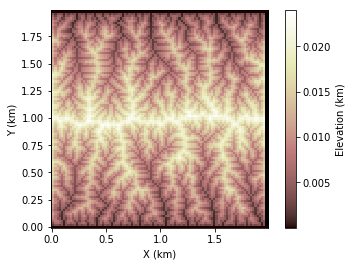

In [18]:
figure('topo without diffusion')
imshow_grid(mg, 'topographic__elevation', grid_units=['km','km'], var_name='Elevation (km)')

And now let's reset the grid elevations and do everything again, but this time, with the diffusion turned *on*:

In [19]:
z[:] = initial_roughness
for i in range(nt):
    lin_diffuse.run_one_step(dt)  # no diffusion this time
    fr.run_one_step() # route_flow isn't time sensitive, so it doesn't take dt as input
    sp.run_one_step(dt)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    if i % 20 == 0:
        print ('Completed loop %d' % i)

Completed loop 0
Completed loop 20
Completed loop 40
Completed loop 60
Completed loop 80
Completed loop 100
Completed loop 120
Completed loop 140
Completed loop 160
Completed loop 180


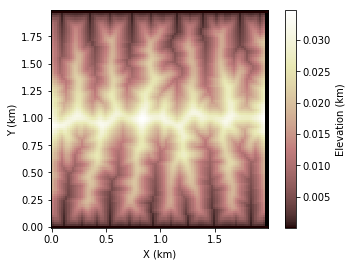

In [20]:
figure('topo with diffusion')
imshow_grid(mg, 'topographic__elevation', grid_units=['km','km'],
            var_name='Elevation (km)')

Beautiful! We've smoothed away the fine-scale channel roughness, as expected, and produced some lovely convex-up hillslopes in its place. Note that even though the initial conditions were identical in both cases, including the roughness, the channel positions have been moved significantly by the hillslope diffusion into the channel.

As a final step, we're going to show off some of Landlab's fancier functionality. We're going to repeat the above coupled model run, but this time we're going to plot some evolving channel profiles, and we're going to drive the simulation with a sequence of storms, not just a fixed timestep. We'll also peoduce a slope-area plot for the final conditions.

Working with timesteps of varying length requires a bit more bookkeeping, but the principle is the same as what we've seen before.

So, load the new landlab objects we'll need, then reset the initial conditions:

In [21]:
from landlab.plot import channel_profile as prf
from landlab.components.uniform_precip import PrecipitationDistribution
from matplotlib.pyplot import loglog

In [22]:
z[:] = initial_roughness

Instantiate the storm generator. This time, we're going to mix an input file for some components with manual definition of others (that we already defined above).

In [23]:
dt = 0.1
total_t = 250.
# re-instantiate the FastscapeEroder, so we can 

storm_inputs = load_params('./coupled_params_storms.txt')
precip = PrecipitationDistribution(total_t=total_t, delta_t=dt, **storm_inputs)
print(storm_inputs)

{'mean_storm_duration': 0.1, 'mean_storm_depth': 0.2, 'mean_interstorm_duration': 0.4}


Now run:

made it to time 0
made it to time 20
made it to time 40
made it to time 60
made it to time 80
made it to time 100
made it to time 120
made it to time 140
made it to time 160
made it to time 180
made it to time 200
made it to time 220
made it to time 240


Text(0.5,1,'Long profiles evolving through time')

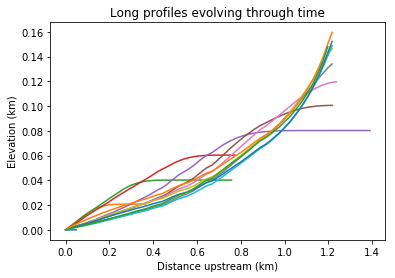

In [24]:
out_interval = 20.
last_trunc = total_t # we use this to trigger taking an output plot
for (interval_duration, rainfall_rate) in precip.yield_storm_interstorm_duration_intensity():
    if rainfall_rate > 0.:
        # note diffusion also only happens when it's raining...
        fr.run_one_step()
        sp.run_one_step(interval_duration)
        lin_diffuse.run_one_step(interval_duration)
    z[mg.core_nodes] += uplift_rate * interval_duration
    this_trunc = precip.elapsed_time // out_interval
    if this_trunc != last_trunc:  # time to plot a new profile!
        print ('made it to time %d' % (out_interval * this_trunc))
        last_trunc = this_trunc
        figure("long_profiles")
        # get and plot the long profile
        profile_structure, distances_upstream = prf.analyze_channel_network_and_plot(mg)
        
    # no need to track elapsed time, as the generator will stop automatically
# make the figure look nicer:
figure("long_profiles")
xlabel('Distance upstream (km)')
ylabel ('Elevation (km)')
title('Long profiles evolving through time')

Note that the "wobbles" in the long profile here are being created by the stochastic storm sequence. We could reduce their impact by reducing the storm-interstorm timescales, or allowing diffusion while it's not raining, but we've chosen not to here to show that the storms are having an effect.

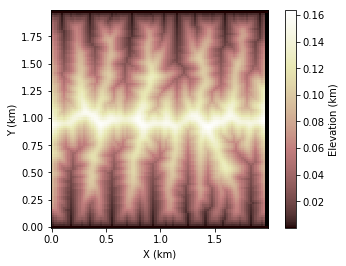

In [25]:
figure('topo with diffusion and storms')
imshow_grid(mg, 'topographic__elevation', grid_units=['km','km'], var_name='Elevation (km)')

We can also plot the location of the channels in map view. 

Here we plot all channel segments with drainage area greater than 0.01 square kilometers in the seven biggest drainage basins. 

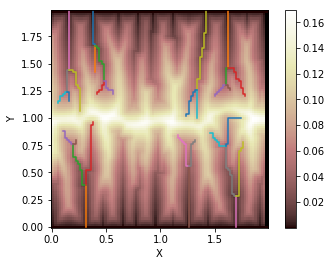

In [26]:
profile_structure, distances_upstream = prf.analyze_channel_network_and_plot(mg,create_plot=False,
                                                                             main_channel_only=False,
                                                                             number_of_channels=7,
                                                                             threshold=0.01)

prf.plot_channels_in_map_view(grid=mg, profile_structure=profile_structure)

Next we make a slope area plot. 

Text(0.5,1,'Slope-Area plot for whole landscape')

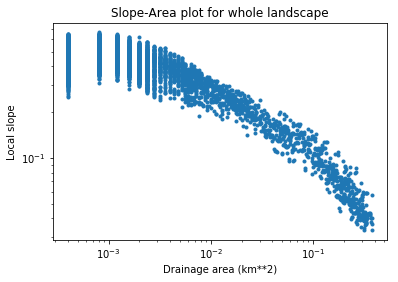

In [27]:
figure('final slope-area plot')
loglog(mg.at_node['drainage_area'], mg.at_node['topographic__steepest_slope'],'.')
xlabel('Drainage area (km**2)')
ylabel('Local slope')
title('Slope-Area plot for whole landscape')

That's a nice set of figures, eh? You can easily spend more time with pylab prettifying them if you want.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>